# Similarity Study: query DBPedia categories, query Garnier Thesaurus categories, save the graphs

The first part of this notebook acquires the ancestors of the given categories from the DBPedia

https://tel.archives-ouvertes.fr/tel-00378201/document

In [2]:
from __future__ import print_function

import os
import sys

import numpy as np
import pandas as pd

import SPARQLWrapper

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import MonaLIA library from the package in the MonaLIA 2.0 project
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
from MonaLIA.util import metadata_helpers as metadata

importlib.reload(metadata)

<module 'MonaLIA.util.metadata_helpers' from 'C:\\Users\\abobashe\\Documents\\MonaLIA\\MonaLIA\\util\\metadata_helpers.py'>

In [59]:
print('SPARQLWrapper ver.', SPARQLWrapper.__version__)
print('Pandas ver.', pd.__version__)

SPARQLWrapper ver. 1.8.5
Pandas ver. 1.1.1


In [9]:
wds_Joconde_Corese = 'http://localhost:8080/sparql'

In [10]:
ancestor_depth = 3
dbp_graph_name = 'DBPedia_unrooted_trimmed'

### Cleanup all entries to the DBPedia subgraph in CORESE

In [6]:
delete_from_graph = '''
prefix ml: <http://ns.inria.fr/monalia/>

DELETE 
{
    graph ml:%s
    {
       ?s ?p ?o
    }
}
where 
{
    graph ml:%s
    {
        ?s ?p ?o
    }
}
''' % (dbp_graph_name, dbp_graph_name)

In [7]:
%time metadata.sparql_service_update(wds_Joconde_Corese, delete_from_graph)

Wall time: 13 ms


'Done'

In [2]:
# list of 102 classes given by MiC

categories = ['"arbre"@fr', '"en buste"@fr', '"fleur"@fr', '"nu"@fr', '"cheval"@fr',
              '"maison"@fr','"oiseau"@fr',   '"bateau"@fr','"église"@fr', '"de profil"@fr',
                      
              '"à mi-corps"@fr', '"chien"@fr', '"de face"@fr', '"ange"@fr', '"couronne"@fr',
              '"livre"@fr', '"chapeau"@fr', '"draperie"@fr', '"château"@fr', '"montagne"@fr', 
                      
              '"croix"@fr', '"cavalier"@fr', '"épée"@fr', '"voiture à attelage"@fr', '"pont"@fr',
              '"main"@fr', '"mer"@fr', '"nudité"@fr', '"feuille"@fr', '"bateau à voiles"@fr', 
              
              '"armure"@fr', '"uniforme"@fr', '"casque"@fr', '"table"@fr', '"tour"@fr',
              '"lion"@fr', '"drapeau"@fr', '"mouton"@fr', '"nuage"@fr', '"robe"@fr',

              '"bâton"@fr', '"port"@fr', '"parc"@fr', '"manteau"@fr', '"vache"@fr',
              '"escalier"@fr', '"fusil"@fr', '"lit"@fr', '"pêche"@fr', '"cerf"@fr',
                      
              '"cimetière"@fr', '"bouclier"@fr', '"sanglier"@fr', '"porte"@fr', '"fenêtre"@fr',
              '"arcade"@fr', '"chaise"@fr', '"pot"@fr', '"flèche"@fr', '"poisson"@fr',
                      
              '"Christ en croix"@fr', '"chaussure"@fr', '"trône"@fr', '"bonnet"@fr', '"papillon"@fr',
              '"chat"@fr', '"arc"@fr', '"lyre"@fr', '"tonneau"@fr', '"tente"@fr',
                      
              '"singe"@fr', '"sac"@fr', '"bouteille"@fr', '"plage"@fr', '"neige"@fr',
              '"flûte"@fr', '"éventail"@fr', '"échelle"@fr', '"moulin à vent"@fr', '"rideau"@fr',

              '"arènes"@fr', '"éléphant"@fr', '"pipe"@fr', '"lettre"@fr', '"phare"@fr',
              '"roue"@fr', '"horloge"@fr', '"couteau"@fr', '"guitare"@fr', '"train"@fr',
                      
              '"harpe"@fr', '"automobile"@fr', '"arc monumental"@fr', '"assiette"@fr', '"ours"@fr', 
              '"seau"@fr', '"bicyclette"@fr', '"pyramide"@fr', '"grenouille"@fr', '"avion"@fr',

              '"piano"@fr', '"aérostat"@fr']


include_terms = ' '.join(['(%s)' % x for x in categories[:40] ])

### Map Garnier Thesaurus categories with DBPedia categories (available in Joconde)

In [71]:
query_map_categories = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
prefix dbpedia-owl: <http://dbpedia.org/ontology/>
prefix dcterms: <http://purl.org/dc/terms/>
prefix ml: <http://ns.inria.fr/monalia/>
prefix dc: <http://purl.org/dc/elements/1.1/>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>

select distinct ?jcl_category ?jcl_label 
                ?dbp_resource ?dbp_label
                ?dbp_resource_new 
                ?dbp_category ?dbp_category_label 
where {

    VALUES(?jcl_label) { %s }

    ?jcl_category a jcl:Term;
                   skos:inScheme <http://data.culture.fr/thesaurus/resource/ark:/67717/T523>;
                   skos:prefLabel ?jcl_label.

    ?jcl_category jcl:dbpediaResource ?dbp_resource;
       jcl:wikipediaLabel ?dbp_label.
       
       
    # jcl:dbpediaResource does not work with resources that have whitespaces 
    # create URI from lables
    bind (uri(concat ("http://fr.dbpedia.org/resource/",
                      replace(?dbp_label, " ", "_" ))) as ?dbp_resource_new)
                      
    optional{                     
        ?jcl_category jcl:dbpediaField [dc:language "en"; 
                             jcl:dbpediaFieldLabel ?dbp_label_en]  
    
        bind (uri(concat ("http://dbpedia.org/resource/",
                           replace(?dbp_label_en, " ", "_" ))) as ?dbp_resource_en)
    }
                      
    service <http://fr.dbpedia.org/sparql/> {
        select *
        where {
           ?dbp_resource_new dcterms:subject ?dbp_category.
           ?dbp_category skos:prefLabel ?dbp_category_label.
        } 
    } 

   bind ( lcase(?dbp_category_label) as ?dbp_category_label_lower ).
   filter(?dbp_category_label = ?dbp_label  || ?dbp_category_label_lower = ?jcl_label ||
          ?dbp_category_label in ( "Panthera leo"@fr, "Bovidae"@fr, "Vêtement mixte"@fr, "Tour (construction)"@fr) )
}


''' % (include_terms)

In [73]:
%%time 

jcl_dbp_map_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_map_categories)
print(jcl_dbp_map_df.shape)

(37, 7)
Wall time: 1min 49s


In [74]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 9999)
jcl_dbp_map_df.head()

,jcl_category,jcl_label,dbp_resource,dbp_label,dbp_resource_new,dbp_category,dbp_category_label
0,http://data.culture.fr/thesaurus/resource/ark:/67717/T523-1220,arbre,http://fr.dbpedia.org/resource/Arbre,Arbre,http://fr.dbpedia.org/resource/Arbre,http://fr.dbpedia.org/resource/Catégorie:Arbre,Arbre
1,http://data.culture.fr/thesaurus/resource/ark:/67717/T523-175,en buste,http://fr.dbpedia.org/resource/Buste,Buste,http://fr.dbpedia.org/resource/Buste,http://fr.dbpedia.org/resource/Catégorie:Buste,Buste
2,http://data.culture.fr/thesaurus/resource/ark:/67717/T523-1051,fleur,http://fr.dbpedia.org/resource/Fleur,Fleur,http://fr.dbpedia.org/resource/Fleur,http://fr.dbpedia.org/resource/Catégorie:Fleur,Fleur
3,http://data.culture.fr/thesaurus/resource/ark:/67717/T523-2224,nu,http://fr.dbpedia.org/resource/Nu_%28genre_artistique%29,Nu (genre artistique),http://fr.dbpedia.org/resource/Nu_(genre_artistique),http://fr.dbpedia.org/resource/Catégorie:Nu,Nu
4,http://data.culture.fr/thesaurus/resource/ark:/67717/T523-2037,cheval,http://fr.dbpedia.org/resource/Cheval,Cheval,http://fr.dbpedia.org/resource/Cheval,http://fr.dbpedia.org/resource/Catégorie:Cheval,Cheval


__NOTES__:
jcl categories = 40
categories with dbpedia resource mapped in jcl = 37 (- "à mi-corps"@fr, "de face"@fr, "de profil"@fr)

categories with new dbpedia resource (created from the label) = 13 ("armure"@fr, "cavalier"@fr, "château"@fr, "couronne"@fr, "croix"@fr, "livre"@fr, "nu"@fr, "nudité"@fr, "robe"@fr, "tour"@fr, "voiture à attelage"@fr, "église"@fr, "épée"@fr)

categories with the same Label as  dbpedia resources = 27

dbpedia categories with labels correspondining to either Joconde label or resource label = 33 (- "lion"@fr, "mouton"@fr, "robe"@fr, "tour"@fr)

for 4 categories that are missing the automatic mappings create explicitly : 
"lion"@fr = "Panthera leo"@fr
"mouton"@fr = "Bovidae"@fr
"robe"@fr = "Vêtement mixte"@fr
"tour"@fr = "Tour (construction)"@fr

### Insert mappings to the DBPedia subgraph 

In [75]:
insert_categories_map = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
prefix dbpedia-owl: <http://dbpedia.org/ontology/>
prefix dcterms: <http://purl.org/dc/terms/>
prefix ml: <http://ns.inria.fr/monalia/>
prefix dc: <http://purl.org/dc/elements/1.1/>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>

insert   
{
    graph ml:%s
    {
       ?jcl_category skos:closeMatch ?dbp_category;
                     ml:label ?jcl_label.
       ?dbp_category skos:prefLabel ?dbp_category_label;
    }
}
where {
{
    select distinct ?jcl_category ?jcl_label 
                    ?dbp_resource ?dbp_label
                    ?dbp_resource_new 
                    ?dbp_category ?dbp_category_label 
    where {

    {
      VALUES(?jcl_label) { %s }
    }

    ?jcl_category a jcl:Term;
                   skos:inScheme <http://data.culture.fr/thesaurus/resource/ark:/67717/T523>;
                   skos:prefLabel ?jcl_label.

    ?jcl_category jcl:dbpediaResource ?dbp_resource;
       jcl:wikipediaLabel ?dbp_label.
       
       
    # jcl:dbpediaResource does not work with resources that have whitespaces 
    # create URI from lables
    bind (uri(concat ("http://fr.dbpedia.org/resource/",
                      replace(?dbp_label, " ", "_" ))) as ?dbp_resource_new)
                      
    #optional{                     
    #    ?jcl_category jcl:dbpediaField [dc:language "en"; 
    #                         jcl:dbpediaFieldLabel ?dbp_label_en]  
    #
    #    bind (uri(concat ("http://dbpedia.org/resource/",
    #                       replace(?dbp_label_en, " ", "_" ))) as ?dbp_resource_en)
    #}
                      
    service <http://fr.dbpedia.org/sparql/> {
        select *
        where {
           ?dbp_resource_new dcterms:subject ?dbp_category.
           ?dbp_category skos:prefLabel ?dbp_category_label.
        } 
    } 

   bind ( lcase(?dbp_category_label) as ?dbp_category_label_lower ).
   filter(?dbp_category_label = ?dbp_label  || ?dbp_category_label_lower = ?jcl_label ||
          ?dbp_category_label in ( "Panthera leo"@fr, "Bovidae"@fr, "Vêtement mixte"@fr, "Tour (construction)"@fr) )
    
    }
}
}

''' % (dbp_graph_name, include_terms)

In [76]:
%time metadata.sparql_service_update(wds_Joconde_Corese, insert_categories_map)

Wall time: 1min 57s


'Done'

In [77]:
query_dbp_subgraph_map = '''
prefix ml: <http://ns.inria.fr/monalia/>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select ?jcl_category  ?jcl_label ?dbp_category
where {
     graph ml:%s {
       ?jcl_category skos:closeMatch ?dbp_category;
                   ml:label ?jcl_label.
       }
}

''' % (dbp_graph_name)

In [78]:
%time jcl_dbp_mapping_graph_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_dbp_subgraph_map)
print(jcl_dbp_mapping_graph_df.shape)

Wall time: 1min 34s
(37, 3)


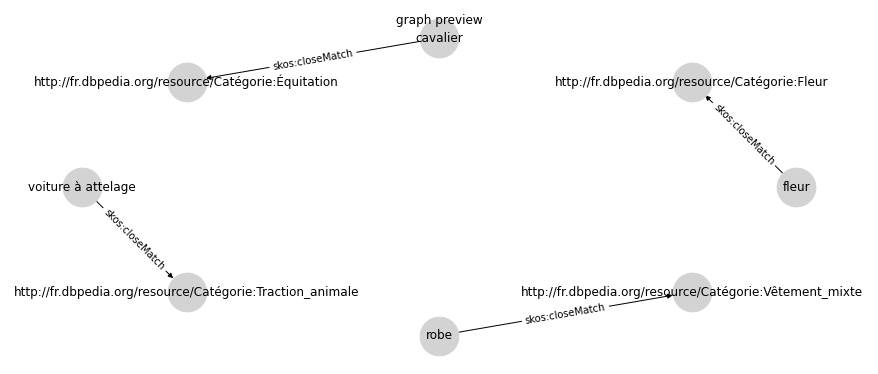

In [79]:
fig=plt.figure(figsize=(12, 5))

fig.suptitle('mapping preview')

# Build your graph

G=nx.from_pandas_edgelist(jcl_dbp_mapping_graph_df[:4], 'jcl_label', 'dbp_category', edge_attr=True,
                                   create_using=nx.DiGraph())

edge_labels = {(u,v) : 'skos:closeMatch' for u,v,d in G.edges(data=True)}

pos = nx.shell_layout(G)

nx.draw(G, pos=pos, with_labels=True, node_size=1500, node_color="lightgrey")#, node_shape="s", alpha=0.5)#, linewidths=20)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
plt.show()


### Query DBPedia ancestors of each mapped category
The query and insert runs separately for each category to avoid timeouts

In [80]:
query_dbp_ancestors_one_by_one_template = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select distinct ?dbp_category  ?sub_category  ?parent_category ?sub_category_label ?parent_category_label
where {

     service <http://fr.dbpedia.org/sparql/> {
     select distinct ?dbp_category ?sub_category  ?parent_category ?sub_category_label  ?parent_category_label
     where {
       ?dbp_category skos:broader{0,%d} ?sub_category .
       ?sub_category skos:broader ?parent_category.
       filter (?dbp_category = <%s>)
       
       
       ?sub_category skos:prefLabel ?sub_category_label.
       ?parent_category skos:prefLabel ?parent_category_label.
       
       filter (!strstarts(?parent_category_label, "Index de") && !strstarts(?parent_category_label, "Liste ") )
       filter (!strstarts(?sub_category_label, "Index de") && !strstarts(?sub_category_label, "Liste ") )
       #filter (!strstarts(?sub_category_label, concat(?parent_category_label, " ")))
     } 

  }
}
order by ?dbp_category  ?sub_category  ?parent_category

'''

insert_dbp_ancestors_one_by_one_template = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix ml: <http://ns.inria.fr/monalia/>

insert   
{
    graph ml:%s
    {
       ?sub_category rdfs:subClassOf ?parent_category.
       
       ?sub_category skos:prefLabel ?sub_category_label.
       ?parent_category skos:prefLabel ?parent_category_label.
    }
}
where {

     service <http://fr.dbpedia.org/sparql/> {
     select distinct ?dbp_category ?sub_category  ?parent_category ?sub_category_label  ?parent_category_label
     where {
       ?dbp_category skos:broader{0,%d} ?sub_category .
       ?sub_category skos:broader ?parent_category.
       filter (?dbp_category = <%s>)
       
       
       ?sub_category skos:prefLabel ?sub_category_label.
       ?parent_category skos:prefLabel ?parent_category_label.
       
       filter (!strstarts(?parent_category_label, "Index de") && !strstarts(?parent_category_label, "Liste ") )
       filter (!strstarts(?sub_category_label, "Index de") && !strstarts(?sub_category_label, "Liste ") )
       #filter (!strstarts(?sub_category_label, concat(?parent_category_label, " ")))
     } 

  }
}

'''

In [81]:
#print(insert_dbp_ancestors_one_by_one_template % (ancestor_depth, 
#                                                  ancestor_depth, 
#                                                  jcl_dbp_mapping_graph_df.dbp_category.sort_values(ignore_index=True)[0]) )

In [82]:
dbp_graph_preview_df = None
for dbp_category in jcl_dbp_mapping_graph_df.dbp_category.sort_values(ignore_index=True):
    print(dbp_category, ' ', end = '')
    res = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_dbp_ancestors_one_by_one_template % (ancestor_depth,
                                                                                                              dbp_category))
    print(res.shape, end='') 
    if (dbp_graph_preview_df is None):
        dbp_graph_preview_df = res.copy()
    else:
        dbp_graph_preview_df = dbp_graph_preview_df.append(res.copy())
   
    print('Done')  

http://fr.dbpedia.org/resource/Catégorie:Ange  (66, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Arbre  (14, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Armure  (52, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Bateau  (43, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Bovidae  (10, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Buste  (9, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Casque  (75, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Chapeau  (15, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Cheval  (36, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Chien  (45, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Château  (77, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Couronne  (33, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Croix  (20, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Drapeau  (44, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Feuille  (13, 5)Done
http://fr.dbpedia.org/resource/Catégorie:Fleur  (39, 5)Done
http://fr.dbpedia.org/res

In [83]:
print(dbp_graph_preview_df.shape)

# dedupe the results
dbp_graph_preview_df.drop_duplicates(subset=['sub_category', 'parent_category'], inplace= True)
print(dbp_graph_preview_df.shape)


(1324, 5)
(807, 5)


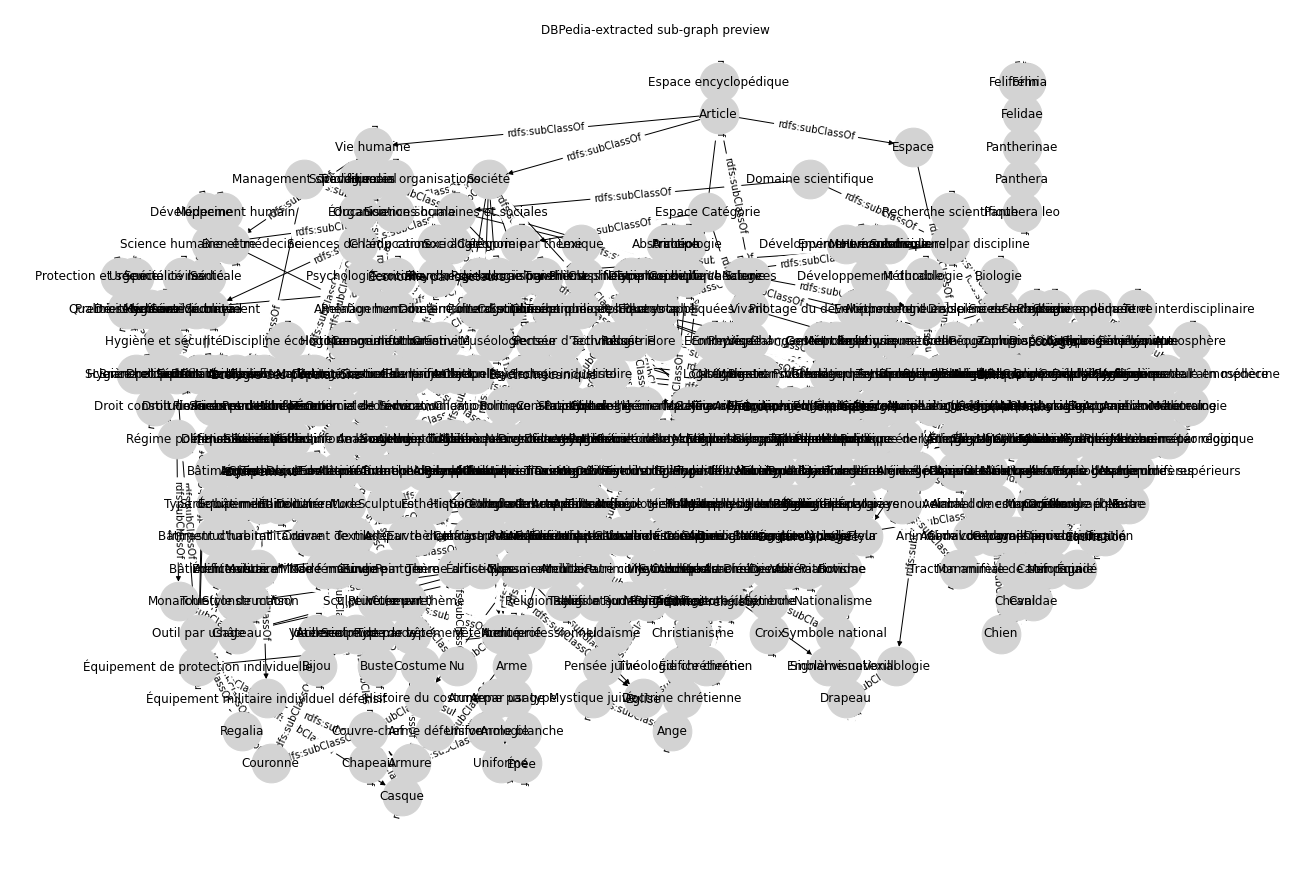

In [84]:
fig=plt.figure(figsize=(18, 12))

fig.suptitle('DBPedia-extracted sub-graph preview')

# Build your graph
G=nx.from_pandas_edgelist(dbp_graph_preview_df, 
                          'parent_category_label', 
                          'sub_category_label', 
                          edge_attr=True,
                          create_using=nx.DiGraph())

edge_labels = {(u,v) : 'rdfs:subClassOf' for u,v,d in G.edges(data=True)}

#pos = nx.shell_layout(G)

pos=graphviz_layout(G, prog='dot')

nx.draw(G, pos=pos,
        with_labels=True,
        node_size=1500,
        node_color='lightgrey')#, node_shape="s", alpha=0.5)#, linewidths=20)

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

plt.show()

In [141]:
print('DBPedia {0, %d}' % ancestor_depth)
print(nx.info(G))

DBPedia {0, 3}
Name: 
Type: DiGraph
Number of nodes: 498
Number of edges: 807
Average in degree:   1.6205
Average out degree:   1.6205


In [305]:
sorted(dict(G.in_degree()).items(), key = lambda kv:(kv[1], kv[0]), reverse=False)

[('Accueil', 0),
 ('Activités en informatique', 0),
 ('Afrique', 0),
 ('Algorithmique', 0),
 ('Alimentation humaine', 0),
 ("Ancien empire d'Europe", 0),
 ('Ancien empire en Afrique', 0),
 ('Ancien empire en Asie', 0),
 ('Ancien pays', 0),
 ('Antiquité', 0),
 ('Art oratoire', 0),
 ("Art par forme d'expression et par période", 0),
 ("Association ou organisme lié à l'éducation", 0),
 ('Association ou organisme par secteur', 0),
 ('Catégorie par continent', 0),
 ('Catégorie par période', 0),
 ('Chimie du solide', 0),
 ('Chronologie de la littérature', 0),
 ('Civilisation antique', 0),
 ('Compétition', 0),
 ('Continent', 0),
 ('Culture occidentale', 0),
 ('Culture par période', 0),
 ("Discipline de l'astronomie", 0),
 ('Domaine de la géométrie', 0),
 ('Endocrinologie', 0),
 ('Eutheria', 0),
 ('Fondements des mathématiques', 0),
 ('Futur', 0),
 ('Gnathostome', 0),
 ("Géographie de l'Asie", 0),
 ('Géométrie euclidienne', 0),
 ('Hasard et aléatoire', 0),
 ('Histoire contemporaine', 0),
 ('His

### Insert DBPedia ancestors of each mapped category into local graph dbpedia_ont

This takes substatnial time (35 min on my laptop)

In [85]:
for dbp_category in jcl_dbp_mapping_graph_df.dbp_category.sort_values(ignore_index=True):
    print(dbp_category, ' ', end = '')
    metadata.sparql_service_update(wds_Joconde_Corese, insert_dbp_ancestors_one_by_one_template % (dbp_graph_name,
                                                                                                   ancestor_depth,
                                                                                                   dbp_category))
    print('Done')

http://fr.dbpedia.org/resource/Catégorie:Ange  Done
http://fr.dbpedia.org/resource/Catégorie:Arbre  Done
http://fr.dbpedia.org/resource/Catégorie:Armure  Done
http://fr.dbpedia.org/resource/Catégorie:Bateau  Done
http://fr.dbpedia.org/resource/Catégorie:Bovidae  Done
http://fr.dbpedia.org/resource/Catégorie:Buste  Done
http://fr.dbpedia.org/resource/Catégorie:Casque  Done
http://fr.dbpedia.org/resource/Catégorie:Chapeau  Done
http://fr.dbpedia.org/resource/Catégorie:Cheval  Done
http://fr.dbpedia.org/resource/Catégorie:Chien  Done
http://fr.dbpedia.org/resource/Catégorie:Château  Done
http://fr.dbpedia.org/resource/Catégorie:Couronne  Done
http://fr.dbpedia.org/resource/Catégorie:Croix  Done
http://fr.dbpedia.org/resource/Catégorie:Drapeau  Done
http://fr.dbpedia.org/resource/Catégorie:Feuille  Done
http://fr.dbpedia.org/resource/Catégorie:Fleur  Done
http://fr.dbpedia.org/resource/Catégorie:Livre  Done
http://fr.dbpedia.org/resource/Catégorie:Main  Done
http://fr.dbpedia.org/resource/

### Connect the top categories to a 'root' rdfs:Resourse 

this step can be skipped

In [97]:
insert_dbp_root = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix ml: <http://ns.inria.fr/monalia/>

insert 
{
    graph ml:%s
    {
       ?top_cat rdfs:subClassOf rdfs:Resource.
    }
    
}
where
{
    graph ml:%s
    {
        ?top_cat  skos:prefLabel  ?label_A.
       filter ( ! EXISTS {
         ?top_cat  rdfs:subClassOf ?cat_C
        })
    }

}

''' % (dbp_graph_name, dbp_graph_name)

# define the delete query in case you need to undo insert

delete_dbp_root = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix ml: <http://ns.inria.fr/monalia/>

delete 
{
    graph ml:%s
    {
       ?top_cat rdfs:subClassOf rdfs:Resource.
    }
    
}
where
{
    graph ml:%s
    {
        ?top_cat rdfs:subClassOf rdfs:Resource.
    }

}

''' % (dbp_graph_name, dbp_graph_name)

In [98]:
%time metadata.sparql_service_update(wds_Joconde_Corese, insert_dbp_root)

Wall time: 24.6 ms


'Done'

### Query just created DBPedia subgraph 

In [99]:
query_dbp_subgraph = '''
prefix ml: <http://ns.inria.fr/monalia/>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select ?sub_category ?parent_category ?sub_category_label ?parent_category_label
where {
     graph ml:%s { 
       ?sub_category rdfs:subClassOf ?parent_category ;
                     skos:prefLabel ?sub_category_label.
       optional {?parent_category skos:prefLabel ?parent_category_label.}     
       }
}
order by 
?sub_category ?parent_category

''' % (dbp_graph_name)

In [100]:
%time dbp_subgraph_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_dbp_subgraph)
print(dbp_subgraph_df.shape)

Wall time: 60.2 ms
(927, 4)


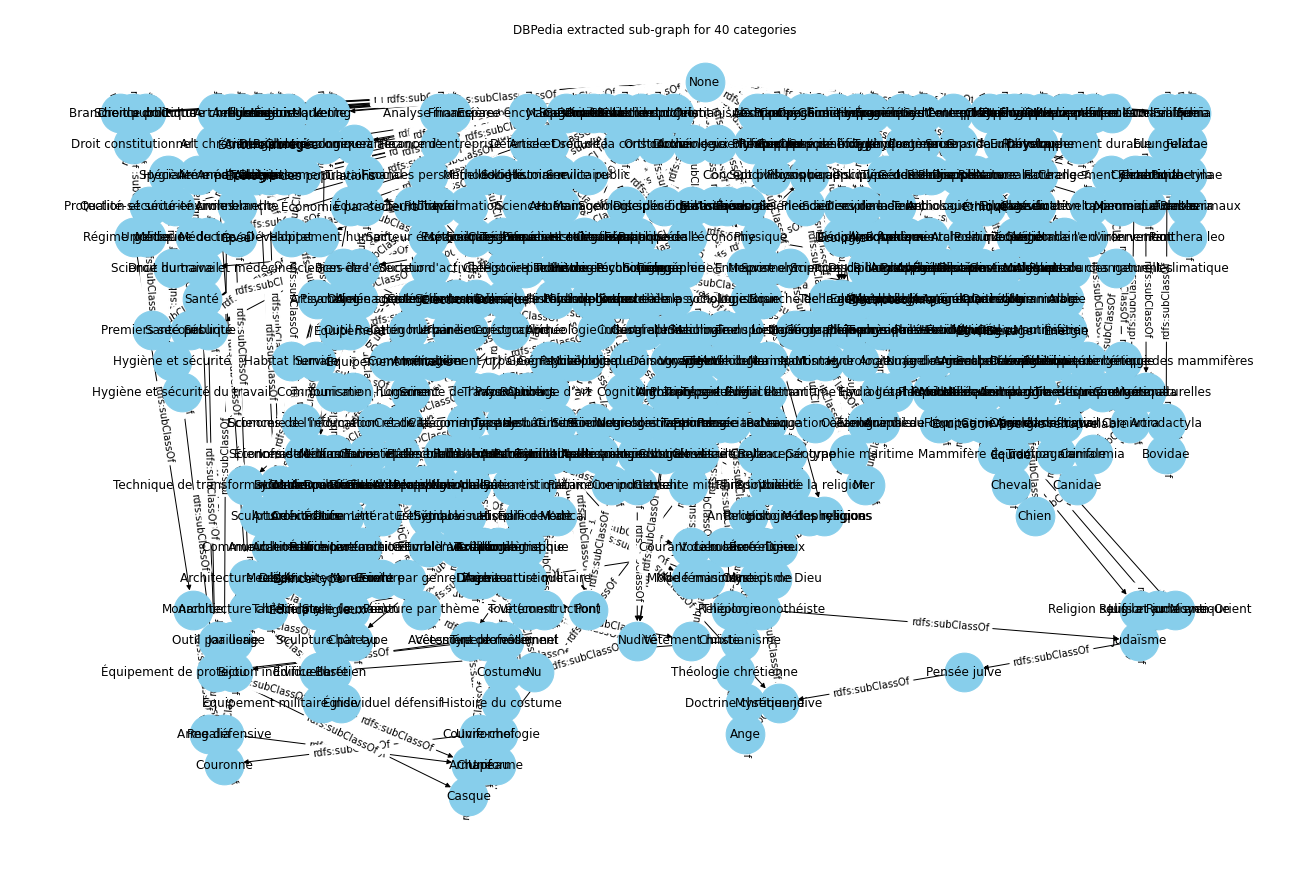

In [101]:
fig=plt.figure(figsize=(18, 12))

fig.suptitle('DBPedia extracted sub-graph for 40 categories')

# Build networkx graph
G=nx.from_pandas_edgelist(dbp_subgraph_df, 
                          'parent_category_label', 
                          'sub_category_label', 
                          edge_attr=True,
                          create_using=nx.DiGraph())

edge_labels = {(u,v) : 'rdfs:subClassOf' for u,v,d in G.edges(data=True)}

#pos = nx.shell_layout(G)

pos=graphviz_layout(G, prog='dot')

nx.draw(G, pos=pos,
        with_labels=True,
        node_size=1500,
        node_color='skyblue')#, node_shape="s", alpha=0.5)#, linewidths=20)

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

plt.show()

In [90]:
print('DBPedia {0, %d}' % ancestor_depth)
print(nx.info(G))

DBPedia {0, 3}
Name: 
Type: DiGraph
Number of nodes: 498
Number of edges: 807
Average in degree:   1.6205
Average out degree:   1.6205


In [59]:
#sorted(dict(G.out_degree()))
sorted(dict(G.in_degree()).items(), key = lambda kv:(kv[1], kv[0]), reverse=False)

[('Accueil', 0),
 ('Activités en informatique', 0),
 ('Afrique', 0),
 ('Algorithmique', 0),
 ('Alimentation humaine', 0),
 ("Ancien empire d'Europe", 0),
 ('Ancien empire en Afrique', 0),
 ('Ancien empire en Asie', 0),
 ('Ancien pays', 0),
 ('Antiquité', 0),
 ('Art oratoire', 0),
 ("Art par forme d'expression et par période", 0),
 ("Association ou organisme lié à l'éducation", 0),
 ('Association ou organisme par secteur', 0),
 ('Catégorie par continent', 0),
 ('Catégorie par période', 0),
 ('Chimie du solide', 0),
 ('Chronologie de la littérature', 0),
 ('Civilisation antique', 0),
 ('Compétition', 0),
 ('Continent', 0),
 ('Culture occidentale', 0),
 ('Culture par période', 0),
 ("Discipline de l'astronomie", 0),
 ('Domaine de la géométrie', 0),
 ('Endocrinologie', 0),
 ('Eutheria', 0),
 ('Fondements des mathématiques', 0),
 ('Futur', 0),
 ('Gnathostome', 0),
 ("Géographie de l'Asie", 0),
 ('Géométrie euclidienne', 0),
 ('Hasard et aléatoire', 0),
 ('Histoire contemporaine', 0),
 ('His

In [91]:
#detect cycles
print( 'is acyclic? ', nx.is_directed_acyclic_graph(G))
print('Cycles:')
list(nx.find_cycle(G))

is acyclic?  False
Cycles:


[('Symbole', 'Dessin'), ('Dessin', 'Symbole')]

### Save created DBPedia sub-graph to a Turtle file

In [128]:
dbp_graph_construct_query = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
prefix ml: <http://ns.inria.fr/monalia/>

    CONSTRUCT {
      graph ml:%s {
          ?s ?p ?o
      }
    }
    WHERE {
      graph ml:%s {
          ?s ?p ?o
      }
    }
''' % (dbp_graph_name, dbp_graph_name)

In [130]:
%%time

results = metadata.sparql_service_construct(wds_Joconde_Corese, dbp_graph_construct_query)

Wall time: 201 ms


In [132]:
results.serialize(destination=os.path.join( os.path.expanduser('~'), 'Documents\MonaLIA\Joconde\similarity', dbp_graph_name.replace('un', '') + '.ttl') ,
                  format='n3',
                  encoding='utf-8')

# Garnier Thesaurus sub-graph

This section of the notebook creates subgraph of Garnier Thesaurus to calculate kg:similarity.

CORESE server 4.1.2 claculates similarity based on the rdfs:subClassOf predicate.

We have to copy the thesaurus portion into a subgraph substituring skos:narrower by rdfs:subClassOf.

In the future versio of CORESE we may not need to do this.

In [108]:
gt_graph_name = 'gt_rooted'

In [109]:
delete_from_gt_ont = '''
prefix ml: <http://ns.inria.fr/monalia/>

DELETE 
{
    graph ml:%s
    {
        ?x ?p ?y
    }
}
where 
{
    graph ml:%s
    {
         ?x ?p ?y
    }
}
''' % (gt_graph_name, gt_graph_name)
%time metadata.sparql_service_update(wds_Joconde_Corese, delete_from_gt_ont)

Wall time: 14 ms


'Done'

In [110]:
query_gt_relations_graph = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>

select ?cat_A 
?label_A
?parent
?parent_label
?parent_parent
?parent_parent_label
 
where {

  VALUES(?label_A) { %s }
  
  ?cat_A a skos:Concept;
                 skos:prefLabel  ?label_A; 
                 skos:broader* ?parent;
                 skos:inScheme <http://data.culture.fr/thesaurus/resource/ark:/67717/T523>.
                 
    ?parent skos:prefLabel ?parent_label.
                 
   optional{
   
      ?parent skos:broader ?parent_parent.
      ?parent_parent skos:prefLabel ?parent_parent_label.
   }
   
}

''' % (include_terms)

In [111]:
%time relations_gt_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_gt_relations_graph)
print(relations_gt_df.shape)

# drop NAs & drop duplicates
relations_gt_df = relations_gt_df[relations_gt_df.parent_parent_label.notna()] \
                                 .drop_duplicates(subset=['parent', 'parent_parent'])

print(relations_gt_df.shape)

Wall time: 1min 47s
(213, 6)
(108, 6)


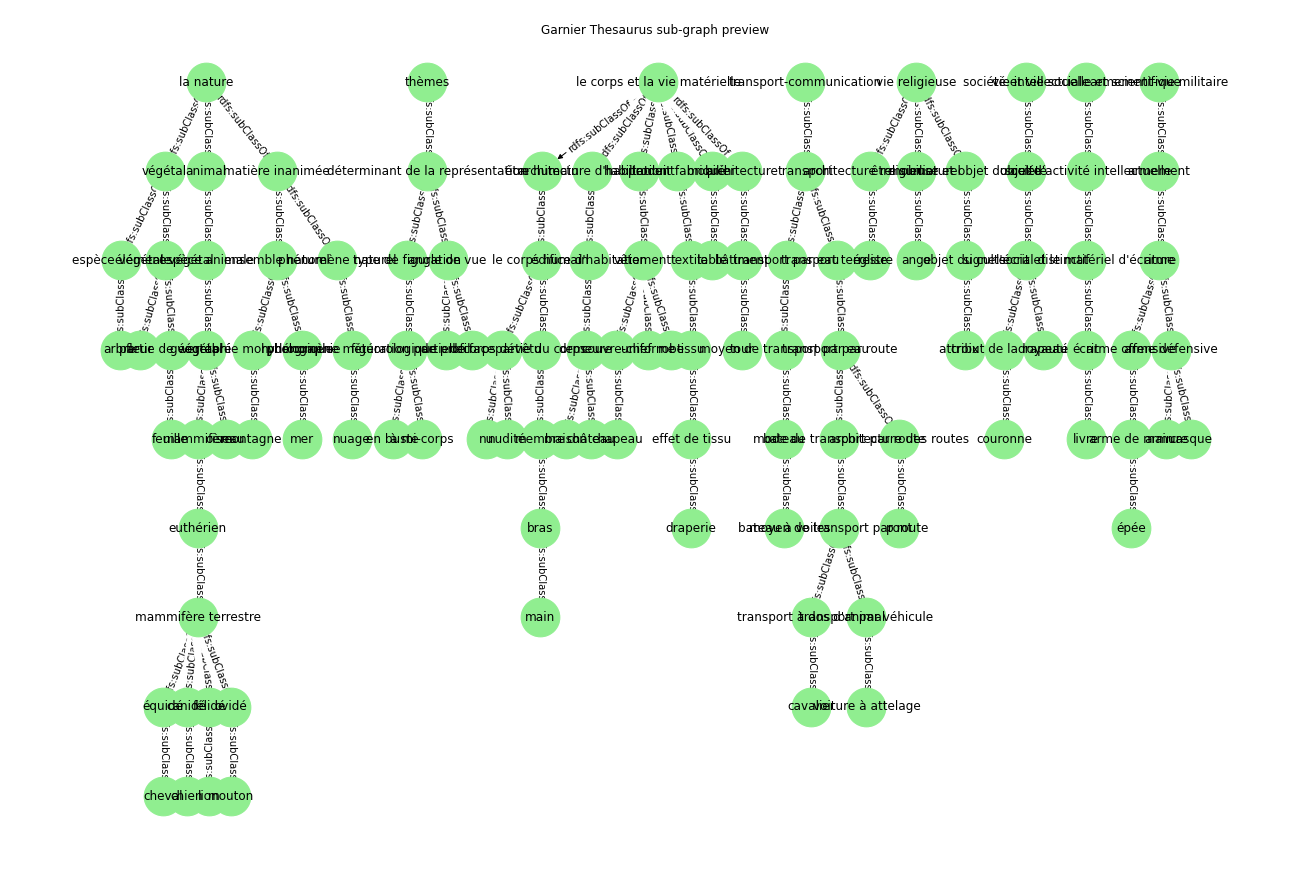

In [114]:
fig=plt.figure(figsize=(18, 12))

fig.suptitle('Garnier Thesaurus sub-graph preview')
# Build your graph
GT=nx.from_pandas_edgelist(relations_gt_df, 
                          'parent_parent_label', 
                          'parent_label', 
                          edge_attr=True,
                          create_using=nx.DiGraph())

edge_labels = {(u,v) : 'rdfs:subClassOf' for u,v,d in GT.edges(data=True)}

#pos = nx.shell_layout(G)

pos=graphviz_layout(GT, prog='dot')

nx.draw(GT, pos=pos,
        with_labels=True,
        node_size=1500,
        node_color='lightgreen')#, node_shape="s", alpha=0.5)#, linewidths=20)

nx.draw_networkx_edge_labels(GT,pos,edge_labels=edge_labels)

plt.show()

In [115]:
print('Garnier Thesaurus graph')
print(nx.info(GT))

Garnier Thesaurus graph
Name: 
Type: DiGraph
Number of nodes: 116
Number of edges: 108
Average in degree:   0.9310
Average out degree:   0.9310


In [116]:
insert_gt_relations_graph = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>

insert {
    graph ml:%s
    {
       ?parent rdfs:subClassOf ?parent_parent.
       
       ?parent skos:prefLabel ?parent_label.
       ?parent_parent skos:prefLabel ?parent_parent_label.
                                     
       ?cat_A ml:label ?label_A
    }

}
where {

 # {
 #     select ?label_A ?cat_A
 #     {
 #         ?classifier rdfs:label "40_classes"; 
 #                    ml:conatainsClass [a ?cat_A ; skos:prefLabel ?label_A].
 #     }
 #     order by ?label_A
 #     #limit 10
 # }
  
  VALUES(?label_A) { %s }
  
  ?cat_A a skos:Concept;
                 skos:prefLabel  ?label_A; 
                 skos:broader* ?parent;
                 skos:inScheme <http://data.culture.fr/thesaurus/resource/ark:/67717/T523>.
                 
    ?parent skos:prefLabel ?parent_label.
                 
   optional{
   
      ?parent skos:broader ?parent_parent.
      ?parent_parent skos:prefLabel ?parent_parent_label.
   }

    
}

''' % (gt_graph_name, include_terms)

In [117]:
%time metadata.sparql_service_update(wds_Joconde_Corese, insert_gt_relations_graph)

Wall time: 1min 56s


'Done'

### Connect the top categories to a 'root' rdfs:Resourse 
this step can be skipped

In [118]:
insert_gt_root = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix ml: <http://ns.inria.fr/monalia/>

insert 
{
    graph ml:%s
    {
       ?top_cat rdfs:subClassOf rdfs:Resource.
    }
    
}
where
{
    graph ml:%s
    {
        ?top_cat  skos:prefLabel  ?label_A.
       filter ( ! EXISTS {
         ?top_cat  rdfs:subClassOf ?cat_C
        })
    }

}

''' % (gt_graph_name, gt_graph_name)

delete_gt_root = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix ml: <http://ns.inria.fr/monalia/>

delete 
{
    graph ml:%s
    {
       ?top_cat rdfs:subClassOf rdfs:Resource.
    }
    
}
where
{
    graph ml:%s
    {
        ?top_cat rdfs:subClassOf rdfs:Resource.
    }

}

''' % (gt_graph_name, gt_graph_name)

In [119]:
%time metadata.sparql_service_update(wds_Joconde_Corese, insert_gt_root)

Wall time: 57.8 s


'Done'

### Query the Garnier Thesaurus subgraph

In [120]:
query_gt_subgraph = '''
prefix ml: <http://ns.inria.fr/monalia/>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select ?sub_category ?parent_category ?sub_category_label ?parent_category_label ?similarity
where {
     graph ml:%s {
       ?sub_category rdfs:subClassOf ?parent_category ;
                     skos:prefLabel ?sub_category_label.
       optional {?parent_category skos:prefLabel ?parent_category_label.}
       
       }
}
order by 
?sub_category ?parent_category
''' % (gt_graph_name)

In [121]:
%time gt_subgraph_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_gt_subgraph)
print(gt_subgraph_df.shape)

Wall time: 46.1 s
(116, 5)


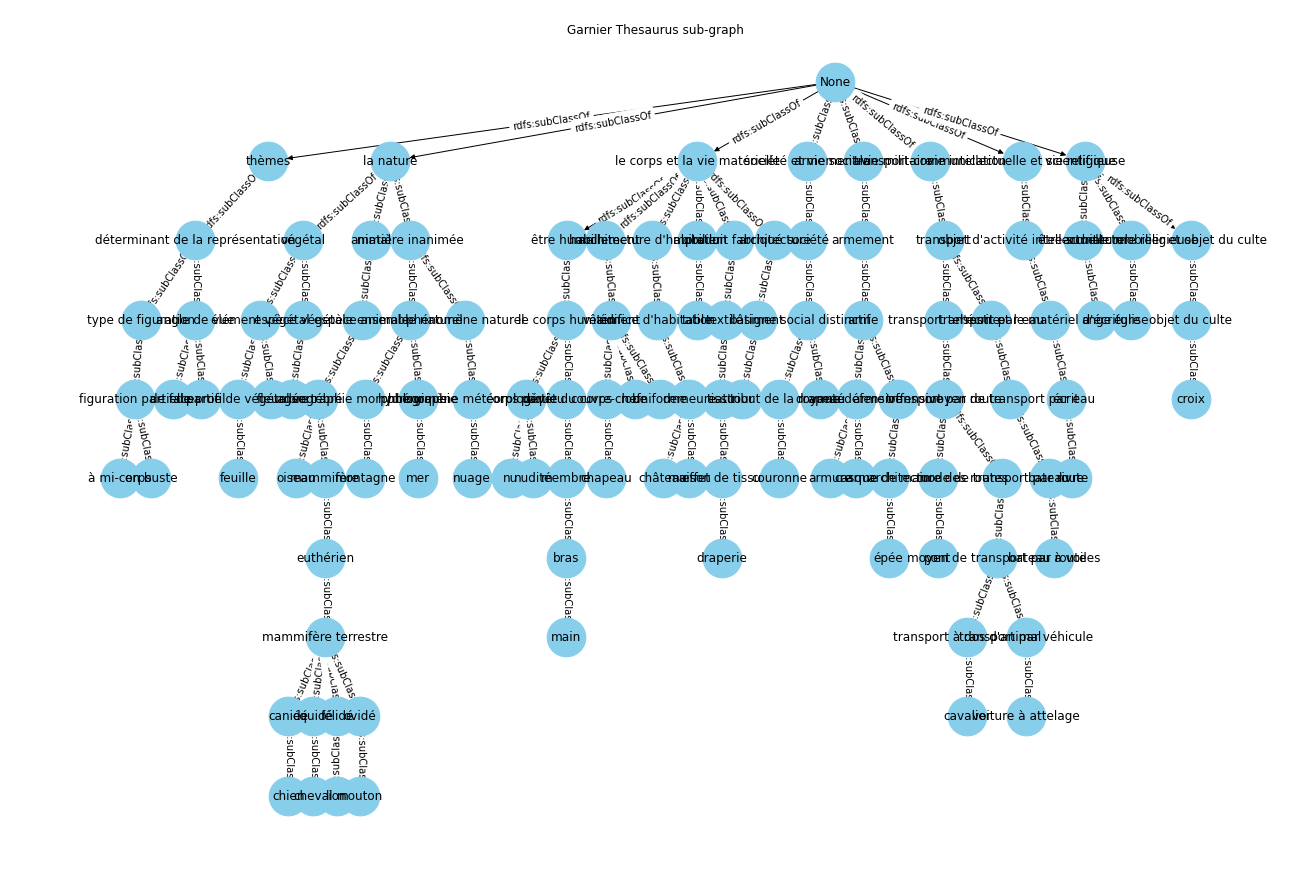

In [122]:
fig=plt.figure(figsize=(18, 12))

fig.suptitle('Garnier Thesaurus sub-graph')
# Build your graph

GT=nx.from_pandas_edgelist(gt_subgraph_df, 
                          'parent_category_label', 
                          'sub_category_label', 
                          edge_attr=True,
                          create_using=nx.DiGraph())

edge_labels = {(u,v) : 'rdfs:subClassOf' for u,v,d in GT.edges(data=True)}

#pos = nx.shell_layout(G)

pos=graphviz_layout(GT, prog='dot')

nx.draw(GT, pos=pos,
        with_labels=True,
        node_size=1500,
        node_color='skyblue')#, node_shape="s", alpha=0.5)#, linewidths=20)

nx.draw_networkx_edge_labels(GT,pos,edge_labels=edge_labels)

plt.show()

In [15]:
print('Granier Thesaurus graph')
print(nx.info(GT))

Granier Thesaurus graph
Name: 
Type: DiGraph
Number of nodes: 116
Number of edges: 108
Average in degree:   0.9310
Average out degree:   0.9310


### Save the Garnier Thesaurus sub-graph as Turtle file

In [123]:
gt_graph_construct_query = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
prefix ml: <http://ns.inria.fr/monalia/>

    CONSTRUCT {
      graph ml:%s {
          ?s ?p ?o
      }
    }
    WHERE {
      graph ml:%s {
          ?s ?p ?o
      }
    }
''' % (gt_graph_name, gt_graph_name)

In [124]:
%%time

results = metadata.sparql_service_construct(wds_Joconde_Corese, gt_graph_construct_query)

Wall time: 4.97 s


In [125]:
results.serialize(destination=os.path.join( os.path.expanduser('~'), 'Documents\MonaLIA\Joconde\similarity', gt_graph_name + '.ttl') ,
                  format='n3',
                  encoding='utf-8')

### To proceed to calculate and visualize similarity data run 

http://localhost:8888/notebooks/Documents/MonaLIA/MonaLIA%202.0/Cooccurence%20Study/MonaLIA.Graph%20Similarity%20Study.load%20and%20plot.ipynb

## Scrapbook

### Exercise in trimming the graph from the top

In [ ]:
trimmed_graph_thesaurus = dbp_thesaurus_graph

levels = 15
for i in range(levels): 
    ct = pd.crosstab(trimmed_graph_thesaurus.parent_category_label, [trimmed_graph_thesaurus.sub_category_label])

    roots = set(ct.index)
    subs = set(ct.columns)

    roots.difference_update(subs)
    
    trimmed_graph_thesaurus = trimmed_graph_thesaurus[~trimmed_graph_thesaurus.parent_category_label.isin(roots)]

    print('roots:' , len(roots), 'trimmed size', trimmed_graph_thesaurus.shape) 

In [ ]:
ct = pd.crosstab(trimmed_graph_thesaurus.parent_category_label, [trimmed_graph_thesaurus.sub_category_label])

roots = set(ct.index)
subs = set(ct.columns)

roots.difference_update(subs)
roots    

In [ ]:
fig=plt.figure(figsize=(18, 12))

#fig.suptitle('DBPedia extracted sub-graph for 40 categories')
# Build your graph

G=nx.from_pandas_edgelist(trimmed_graph_thesaurus, 
                          'parent_category_label', 
                          'sub_category_label', 
                          edge_attr=True,
                          create_using=nx.DiGraph())

edge_labels = {(u,v) : 'rdfs:subClassOf' for u,v,d in G.edges(data=True)}

#pos = nx.shell_layout(G)

pos=graphviz_layout(G, prog='dot')

nx.draw(G, pos=pos,
        with_labels=True,
        node_size=1500,
        node_color='skyblue')#, node_shape="s", alpha=0.5)#, linewidths=20)

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

plt.show()

In [15]:
query_gt_relations_graph = '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>

select ?cat_A 
?label_A
?parent
?parent_label
?parent_parent
?parent_parent_label
 
where {

  {
      select ?label_A ?cat_A
      {
          ?classifier rdfs:label "40_classes"; 
                      ml:conatainsClass [a ?cat_A ; skos:prefLabel ?label_A].
      }
      order by ?label_A
      #limit 10
  }
  
  ?A a skos:Concept;
                 skos:prefLabel  ?label_A; 
                 skos:broader* ?parent;
                 skos:inScheme <http://data.culture.fr/thesaurus/resource/ark:/67717/T523>.
                 
    ?parent skos:prefLabel ?parent_label.
                 
   optional{
   
      ?parent skos:broader ?parent_parent.
      ?parent_parent skos:prefLabel ?parent_parent_label.
   }

    
}

''' 